In [167]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os,time,datetime,sys

### 1D Inviscid Euler Equation

$$

\begin{aligned}
&\partial_t U + \nabla\cdot f(U)=0, \quad  x\in\Omega\subset\mathbb{R},t\in(0,T] \\

& U = \begin{bmatrix}
\rho \\
\rho u
\end{bmatrix}
\quad
f(U) = \begin{bmatrix}
\rho u\\
\rho u^2 +p 
\end{bmatrix} \\
\\
&\text{IC}\\
& \qquad \text{initial shock is given at } x=0.5\\
& \qquad (\rho_L,u_L,p_L)=(1.4,0.1,1.0) \qquad (\rho_R,u_R,p_R)=(1.0,0.1,1.0) \\
&\text{BC} \quad x\in[0,1]\\
&\qquad \text{Dirichlet boundary}

&\text{exact solution} \\
&\qquad \rho(x,t)=\left\{
    \begin{aligned}
        1.4 \quad x<0.5+0.1t \\
        1.0 \quad x>0.5+0.1t
    \end{aligned}
\right.

\quad u(x,t)=0.1 \quad p(x,t)=1.0

\end{aligned}

$$


### PINNs Model

In [168]:
class PINN(tf.keras.Model):
    def __init__(
            self,
            t,x,u,t_r,x_r,lb,ub,
            in_dim,out_dim,width,depth,
            activ="tanh",w_init="glorot_normal",b_init="zeros",
            lr=1e-3,opt="Adam",
            info_seed=1234):
        super().__init__()
        # information
        self.info_seed = info_seed
        # initial the data
        self.data_type = tf.float32
        self.x = tf.convert_to_tensor(x,dtype=self.data_type)
        self.t = tf.convert_to_tensor(t,dtype=self.data_type)
        self.u = tf.convert_to_tensor(u,dtype=self.data_type)
        # pde loss train point = inner + outer(initial+boundary)
        t_r = tf.concat([t,t_r],axis=0)
        x_r = tf.concat([x,x_r],axis=0)
        self.x_r = tf.convert_to_tensor(x_r,dtype=self.data_type)
        self.t_r = tf.convert_to_tensor(t_r,dtype=self.data_type)
        self.lb = tf.convert_to_tensor(lb,dtype=self.data_type)
        self.ub = tf.convert_to_tensor(ub,dtype=self.data_type)
        # neuron network configuration
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.width = width
        self.depth = depth
        self.activ = activ
        self.w_init = w_init
        self.b_init = b_init
        self.lr = lr
        self.opt = opt
        
        # call
        self.dnn = self.dnn_init(in_dim,out_dim,width,depth)
        self.params = self.dnn.trainable_variables
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

        # track loss
        self.ep_log = []
        self.loss_log = []

        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         dtype        :", self.data_type)
        print("         activ func   :", self.activ)
        print("         weight init  :", self.w_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         summary      :", self.dnn.summary())
    
    def dnn_init(self,in_dim,out_dim,width,depth):
        net = tf.keras.Sequential()
        net.add(tf.keras.layers.InputLayer(in_dim))
        # net.add(tf.keras.layers.Lambda(lambda x: 2. * (x - self.lb) / (self.ub - self.lb) - 1.))
        for l in range(depth - 1):
            net.add(tf.keras.layers.Dense(units=width, activation = self.activ,kernel_initializer = self.w_init, bias_initializer = self.b_init, ))
        net.add(tf.keras.layers.Dense(out_dim))
        return net

    
    def loss_pde(self):
        with tf.GradientTape(persistent=True) as tp:
            tp.watch(self.t_r)
            tp.watch(self.x_r)
            u = self.dnn(tf.concat([self.t_r,self.x_r],1))
            rho = u[:,0][:,None]
            v = u[:,1][:,None]
            p = u[:,2][:,None]
        rho_t = tp.gradient(rho,self.t_r)
        v_t = tp.gradient(v,self.t_r)
        rho_x = tp.gradient(rho,self.x_r)
        v_x = tp.gradient(v,self.x_r)
        p_x = tp.gradient(p,self.x_r)
        del tp
        equ_1 = rho_t + rho_x*v + rho*v_x
        equ_2 = (rho_t*v + rho*v_t) + (rho*(2*v*v_x) +(v**2)*rho_x + p_x)
        r = tf.reduce_mean(tf.square(equ_1)+tf.square(equ_2))
        return r

    def loss_icbc(self):
        u_nn = self.dnn(tf.concat([self.t,self.x],1))
        return tf.reduce_mean(tf.square(self.u-u_nn))

    @tf.function
    def grad_desc(self):
        with tf.GradientTape() as tp:
            loss = self.loss_pde() + self.loss_icbc()
        grad = tp.gradient(loss,self.params)
        del tp
        self.optimizer.apply_gradients(zip(grad,self.params))
        return loss
    
    def train(self,epoch,tol,info_freq):
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         convergence tol:", tol)
        t0 = time.time()
        for ep in range(epoch+1):
            ep_loss = self.grad_desc()
            if ep % info_freq ==0:
                elps = time.time() -t0
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                print("ep: %d, loss: %.3e, elps: %.3f" % (ep, ep_loss, elps))
                t0 = time.time()
            if ep_loss < tol:
                print(">>>>> end time:", datetime.datetime.now())
                break
        print(">>>>> end time:", datetime.datetime.now())

    def predict(self,t,x):
        t = tf.convert_to_tensor(t,dtype=self.data_type)
        x = tf.convert_to_tensor(x,dtype=self.data_type)
        with tf.GradientTape(persistent=True) as tp:
            tp.watch(t)
            tp.watch(x)
            u = self.dnn(tf.concat([t,x],1))
            rho = u[:,0][:,None]
            v = u[:,1][:,None]
            p = u[:,2][:,None]
        rho_t = tp.gradient(rho,t)
        v_t = tp.gradient(v,t)
        rho_x = tp.gradient(rho,x)
        v_x = tp.gradient(v,x)
        p_x = tp.gradient(p,x)
        del tp
        equ_1 = rho_t + rho_x*v + rho*v_x
        equ_2 = (rho_t*v + rho*v_t) + (rho*(2*v*v_x) +(v**2)*rho_x + p_x)
        gv = tf.square(equ_1)+tf.square(equ_2)
        return u,gv

### Structure of the Costum PINNs

In [169]:
in_dim = 2
out_dim = 3
width = 20
depth = 7

epoch = 12000
tol = 1e-8

N_0 = 60
N_b = 60
N_r = 2000

w_init = "glorot_normal"
b_init = "zeros"
act = "tanh"

lr = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 5e-3,
    decay_steps = epoch,
    alpha = 1e-2
)

opt = "Adam"
info_freq = 500
info_seed = 1234


print("python    :", sys.version)
print("tensorflow:", tf.__version__)
print("rand seed :", info_seed)
os.environ["PYTHONHASHSEED"] = str(info_seed)

python    : 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
tensorflow: 2.9.1
rand seed : 1234


### 1D Inviscid Euler Equation

$$

\begin{aligned}
&\partial_t U + \nabla\cdot f(U)=0, \quad  x\in\Omega\subset\mathbb{R},t\in(0,T] \\

& U = \begin{bmatrix}
\rho \\
\rho u
\end{bmatrix}
\quad
f(U) = \begin{bmatrix}
\rho u\\
\rho u^2 +p 
\end{bmatrix} \\
\\
&\text{BC/IC } \quad [-1,1]\times[0,1]\\
&\qquad U(-1,t) = U(1,t), \quad \nabla U(-1,t)=\nabla U(1,t)\\
&\qquad U_0 = (\rho_0,u_0,p_0) = (1+0.2\sin(\pi x),1,1)\\

&\text{exact solution} \\
&\qquad U = (\rho,u,p) = (1+0.2\sin(\pi(x-t)),1,1)\\

\end{aligned}

$$


In [225]:
tmin, tmax = 0., 2.
xmin, xmax = 0., 1.
lb = tf.constant([tmin, xmin], dtype = tf.float32)
ub = tf.constant([tmax, xmax], dtype = tf.float32)

t_0 = tf.ones((N_0, 1), dtype = tf.float32) * lb[0]
x_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype = tf.float32)
u_0 = tf.convert_to_tensor([[1.4 if x>0.5 else 1.0 ,0.1,1.0] for x in x_0.numpy()],dtype=tf.float32)

t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype = tf.float32)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b, 1), .5, dtype = tf.float32)
u_b = tf.convert_to_tensor([[1.4 if x_b[i]<0.5+0.1*t_b[i] else 1.0 ,0.1 ,1.0] for i in range(len(x_b.numpy()))],dtype=tf.float32)

t = tf.concat([t_0,t_b],axis=0)
x = tf.concat([t_0,t_b],axis=0)
u = tf.concat([u_0,u_b],axis=0)

t_r_rand = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = tf.float32)
x_r_rand = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype = tf.float32)

t_r_clus = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = tf.float32)
noise = 0.1
a = 0.1
b = 0.5
aa = a*(1+np.random.randn()*noise)
bb = b*(1+np.random.randn()*noise)
cc = np.random.choice(range(t_r_clus.shape[0]),size=int(N_r*0.6), replace=False)
x_r_clus =tf.convert_to_tensor([ [a*(1+np.random.randn()*noise)*t_r_clus[i].numpy()[0]+b*(1+np.random.randn()*noise)] if (i in cc) else [np.random.random()] for i in range(len(t_r_clus))],dtype=tf.float32)

In [226]:
x_b.numpy().T.sum()

37.0

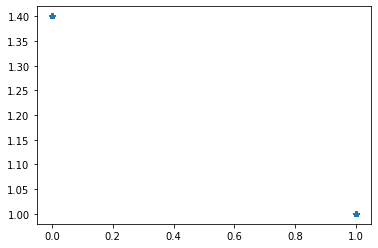

In [227]:
a = x_b.numpy().flatten().reshape(-1,1)
b = u_b[:,0].numpy().reshape(-1,1)
xx=tf.concat([a,b],1)
plt.plot(a,b,"*")

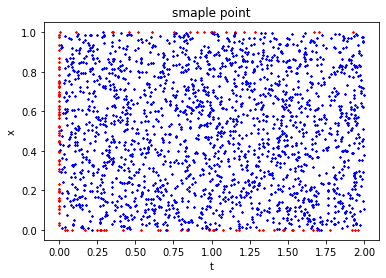

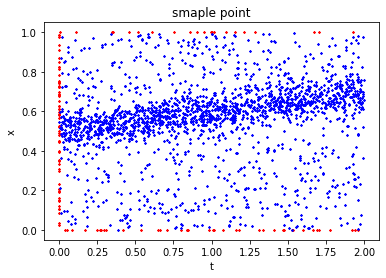

In [171]:
plt.figure(figsize=(6,4))
plt.ylabel("x")
plt.xlabel("t")
plt.title("smaple point")
plt.plot(t_0,x_0,"*",color="r",markersize=2)
plt.plot(t_b,x_b,"*",color="r",markersize=2)
plt.plot(t_r_rand,x_r_rand,"*",color="b",markersize=2)
plt.savefig("uniform sample point")

plt.figure(figsize=(6,4))
plt.ylabel("x")
plt.xlabel("t")
plt.title("smaple point")
plt.plot(t_0,x_0,"*",color="r",markersize=2)
plt.plot(t_b,x_b,"*",color="r",markersize=2)
plt.plot(t_r_clus,x_r_clus,"*",color="b",markersize=2)
plt.savefig("clustered sample point")


In [172]:
pinn_clus = PINN(
            t,x,u,
            t_r_clus,x_r_clus,
            lb,ub,
            in_dim,out_dim,width,depth,
            act,w_init,b_init,
            lr,opt,info_seed)

>>>>> start time: 2022-07-15 23:50:59.233710
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x00000238277A7C10>
         optimizer    : Adam
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 20)                60        
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 20)                420       
                                                              

In [173]:
pinn_clus.train(epoch,tol,info_freq)

>>>>> training setting;
         # of epoch     : 12000
         convergence tol: 1e-08
ep: 0, loss: 1.120e+00, elps: 1.374
ep: 500, loss: 1.252e-02, elps: 2.555
ep: 1000, loss: 1.248e-02, elps: 2.615
ep: 1500, loss: 1.240e-02, elps: 2.546
ep: 2000, loss: 1.234e-02, elps: 2.592
ep: 2500, loss: 1.231e-02, elps: 2.770
ep: 3000, loss: 1.230e-02, elps: 3.079
ep: 3500, loss: 1.230e-02, elps: 3.099
ep: 4000, loss: 1.228e-02, elps: 3.095
ep: 4500, loss: 1.228e-02, elps: 3.084
ep: 5000, loss: 1.237e-02, elps: 3.082
ep: 5500, loss: 1.228e-02, elps: 3.088
ep: 6000, loss: 1.222e-02, elps: 3.066
ep: 6500, loss: 1.180e-02, elps: 3.084
ep: 7000, loss: 1.151e-02, elps: 3.078
ep: 7500, loss: 1.144e-02, elps: 3.060
ep: 8000, loss: 1.139e-02, elps: 3.105
ep: 8500, loss: 1.136e-02, elps: 3.159
ep: 9000, loss: 1.133e-02, elps: 3.112
ep: 9500, loss: 1.130e-02, elps: 3.098
ep: 10000, loss: 1.125e-02, elps: 3.143
ep: 10500, loss: 1.121e-02, elps: 3.141
ep: 11000, loss: 1.118e-02, elps: 3.153
ep: 11500, loss:

In [174]:
pinn_rand = PINN(t,x,u,t_r_rand,x_r_rand,lb,ub,
            in_dim,out_dim,width,depth,
            act,w_init,b_init,
            lr,opt,info_seed)

>>>>> start time: 2022-07-15 23:52:12.965553
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x00000238277A7C10>
         optimizer    : Adam
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 20)                60        
                                                                 
 dense_29 (Dense)            (None, 20)                420       
                                                                 
 dense_30 (Dense)            (None, 20)                420       
                                                                 
 dense_31 (Dense)            (None, 20)                420       
                                                              

In [175]:
pinn_rand.train(epoch,tol,info_freq)

>>>>> training setting;
         # of epoch     : 12000
         convergence tol: 1e-08
ep: 0, loss: 1.104e+00, elps: 1.293
ep: 500, loss: 1.257e-02, elps: 3.104
ep: 1000, loss: 1.253e-02, elps: 3.220
ep: 1500, loss: 1.249e-02, elps: 3.208
ep: 2000, loss: 1.242e-02, elps: 3.202
ep: 2500, loss: 1.234e-02, elps: 3.232
ep: 3000, loss: 1.230e-02, elps: 3.242
ep: 3500, loss: 1.229e-02, elps: 3.235
ep: 4000, loss: 1.227e-02, elps: 3.247
ep: 4500, loss: 1.213e-02, elps: 3.239
ep: 5000, loss: 1.190e-02, elps: 3.280
ep: 5500, loss: 1.185e-02, elps: 3.291
ep: 6000, loss: 1.180e-02, elps: 3.276
ep: 6500, loss: 1.162e-02, elps: 3.293
ep: 7000, loss: 1.148e-02, elps: 3.299
ep: 7500, loss: 1.133e-02, elps: 3.344
ep: 8000, loss: 1.125e-02, elps: 3.333
ep: 8500, loss: 1.118e-02, elps: 3.554
ep: 9000, loss: 1.114e-02, elps: 3.828
ep: 9500, loss: 1.111e-02, elps: 3.619
ep: 10000, loss: 1.109e-02, elps: 3.556
ep: 10500, loss: 1.107e-02, elps: 3.459
ep: 11000, loss: 1.106e-02, elps: 3.427
ep: 11500, loss:

### Visualization

In [176]:
def plot_loss(pinn,savepath="./pics"):
    title = "loss"
    # plt.figure(figsize=(8,4))
    fig1,ax1 = plt.subplots(1)
    ax1.plot(pinn[0].ep_log,pinn[0].loss_log,label="Clus")
    ax1.plot(pinn[1].ep_log,pinn[1].loss_log,label="Rand")
    ax1.grid(alpha=0.5)
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")
    ax1.set_title("train loss")
    ax1.legend(loc='upper right')

    # plt.figure(figsize=(8,4))
    fig2,ax2 = plt.subplots(1)
    ax2.plot(pinn[0].ep_log,pinn[0].loss_log,label="Clus")
    ax2.plot(pinn[1].ep_log,pinn[1].loss_log,label="Rand")
    ax2.grid(alpha=0.5)
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")
    ax2.set_yscale("log")
    ax2.set_title("train loss(log)")
    ax2.legend(loc='upper right')

    # plt.figure(figsize=(8,4))
    fig3,ax3 = plt.subplots(1)
    strt = int(len(pinn[0].ep_log)*0.7)
    ax3.plot(pinn[0].ep_log[strt:],pinn[0].loss_log[strt:],label="Clus")
    ax3.plot(pinn[1].ep_log[strt:],pinn[1].loss_log[strt:],label="Rand")
    ax3.grid(alpha=0.5)
    ax3.set_xlabel("epoch")
    ax3.set_ylabel("loss")
    ax3.legend(loc='upper right')
    ax3.set_title("train loss(part)")

    if not os.path.exists(savepath):
        os.makedirs(savepath)
    fig1.savefig(savepath+"/"+title)
    fig2.savefig(savepath+"/"+title+"(log)")
    fig3.savefig(savepath+"/"+title+"(part")


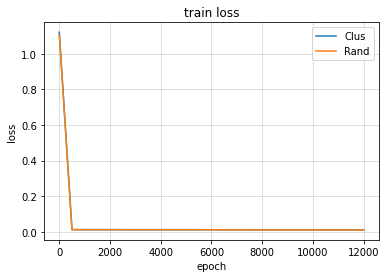

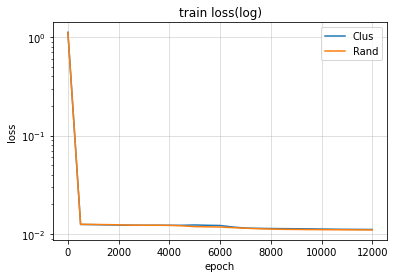

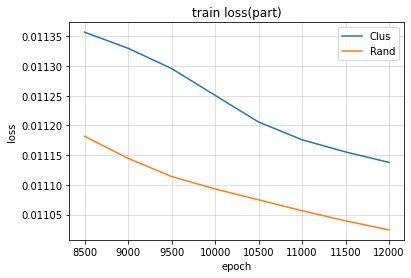

In [177]:
pinn = [pinn_clus,pinn_rand]
plot_loss(pinn)

In [178]:
def plot_solution(X,u,savepath="./pics"):
    lb = X.min(0)
    ub = X.max(0)
    x = np.linspace(lb[0],ub[0],200)
    y = np.linspace(lb[1],ub[1],200)
    x,y = np.meshgrid(x,y)
    density_clus = griddata(X,u[0][:,0].numpy().flatten(),(x,y),method="linear")
    density_rand = griddata(X,u[0][:,0].numpy().flatten(),(x,y),method="linear")
    velocity_clus = griddata(X,u[0][:,1].numpy().flatten(),(x,y),method="linear")
    velocity_rand = griddata(X,u[1][:,1].numpy().flatten(),(x,y),method="linear")
    pressure_clus = griddata(X,u[0][:,2].numpy().flatten(),(x,y),method="linear")
    pressure_rand = griddata(X,u[1][:,2].numpy().flatten(),(x,y),method="linear")

    if not os.path.exists(savepath):
        os.makedirs(savepath)
    fig1,ax1 =plt.subplots(1,2)
    img1 = ax1[0].imshow(density_clus,interpolation='nearest',cmap='rainbow',extent=[0,1,0,1],origin="lower",aspect="auto")
    img2 = ax1[1].imshow(density_rand,interpolation='nearest',cmap='rainbow',extent=[0,1,0,1],origin="lower",aspect="auto")
    plt.colorbar(img1,ax=ax1[0])
    plt.colorbar(img2,ax=ax1[1])
    ax1[0].set_title("Clus density")
    ax1[1].set_title("Rand density")
    ax1[0].set_xlabel('t') 
    ax1[1].set_xlabel('t') 
    ax1[0].set_ylabel('x')
    fig1.savefig(savepath+"/clus density")

    fig2,ax2 =plt.subplots(1,2)
    img1 = ax2[0].imshow(velocity_clus,interpolation='nearest',cmap='rainbow',extent=[0,1,0,1],origin="lower",aspect="auto")
    img2 = ax2[1].imshow(velocity_rand,interpolation='nearest',cmap='rainbow',extent=[0,1,0,1],origin="lower",aspect="auto")
    plt.colorbar(img1,ax=ax2[0])
    plt.colorbar(img2,ax=ax2[1])
    ax2[0].set_title("Clus velocity")
    ax2[1].set_title("Rand velocity")
    ax2[0].set_xlabel('t')
    ax2[1].set_xlabel('t')
    ax2[0].set_ylabel('x')
    fig2.savefig(savepath+"/clus velocity")

    fig3,ax3 =plt.subplots(1,2)
    img1 = ax3[0].imshow(pressure_clus,interpolation='nearest',cmap='rainbow',extent=[0,1,0,1],origin="lower",aspect="auto")
    img2 = ax3[1].imshow(pressure_rand,interpolation='nearest',cmap='rainbow',extent=[0,1,0,1],origin="lower",aspect="auto")
    plt.colorbar(img1,ax=ax3[0])
    plt.colorbar(img2,ax=ax3[1])
    ax3[0].set_title("Clus pressure")
    ax3[1].set_title("Rand pressure")
    ax3[0].set_xlabel('t') 
    ax3[1].set_xlabel('t') 
    ax3[0].set_ylabel('x')
    fig3.savefig(savepath+"/clus pressure")

In [230]:
def plot_final(X,u,final_t,savepath="./pics"):
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    index = np.array([ [i,x[1]] for i,x in enumerate(TX) if x[0]==final_t])
    density_clus = [u[0][:,0][int(i)] for i in index[:,0]]
    density_rand = [u[0][:,0][int(i)] for i in index[:,0]]
    velocity_clus = [u[1][:,1][int(i)] for i in index[:,0]]
    velocity_rand = [u[1][:,1][int(i)] for i in index[:,0]]
    pressure_clus = [u[1][:,2][int(i)] for i in index[:,0]]
    pressure_rand = [u[1][:,2][int(i)] for i in index[:,0]]
    xx = index[:,1]

    fig1,ax1 = plt.subplots(1)
    ax1.set_title(f"density(t={final_t})")
    ax1.set_xlabel('x')
    ax1.set_ylabel('density')
    ax1.plot(xx,density_clus,"*",label="Clus NN")
    ax1.plot(xx,density_rand,"o",color="orange",label="Rand NN",markersize=3)
    yy = np.array([1.4 if x<0.5+0.1*final_t else 1.0 for x in xx])
    ax1.plot(xx,yy,color="r",label='exact')
    ax1.legend(loc="upper right")
    # fig1.tight_layout()
    fig1.savefig(f"{savepath}/density(t={final_t}).png")

    fig2,ax2 = plt.subplots(1)
    ax2.set_title(f"velocity(t={final_t})")
    ax2.set_xlabel('x')
    ax2.set_ylabel('velocity')
    ax2.plot(xx,velocity_clus,"*",label="Clus NN")
    ax2.plot(xx,velocity_rand,"o",color="orange",label="Rand NN",markersize=3)
    ax2.plot(xx,np.ones(len(xx)),color="r",label="exact")
    ax2.legend(loc="upper right")
    ax2.axis(ymin=0.95,ymax=1.05)
    fig2.savefig(f"{savepath}/velocity(t={final_t}.png")

    fig3,ax3 = plt.subplots(1)
    ax3.set_title(f"pressure(t={final_t})")
    ax3.set_xlabel('x')
    ax3.set_ylabel('pressure')
    ax3.plot(xx,pressure_clus,"*",label="Clus NN")
    ax3.plot(xx,pressure_rand,"o",color="orange",label="Rand NN",markersize=3)
    ax3.plot(xx,np.ones(len(xx)),color="r",label="exact")
    ax3.legend(loc="upper right")
    ax3.axis(ymin=0.95,ymax=1.05)
    fig3.savefig(f"{savepath}/pressure(t={final_t}).png")

In [180]:
t = np.linspace(tmin,tmax,1001)
x = np.linspace(xmin,xmax,101)
t,x = np.meshgrid(t,x)
t = t.reshape(-1, 1)
x = x.reshape(-1, 1)
TX = np.c_[t,x]

In [181]:
u_clus,r_clus = pinn_clus.predict(t,x)
u_rand,r_rand = pinn_rand.predict(t,x)
u = [u_clus,u_rand]

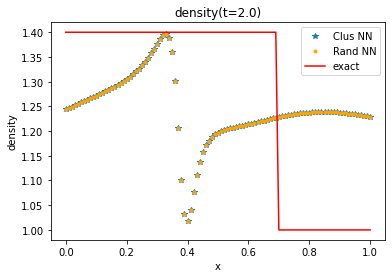

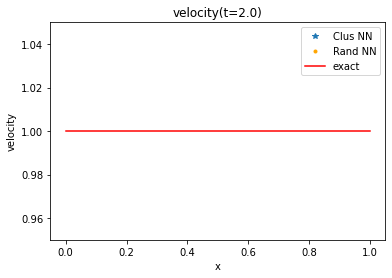

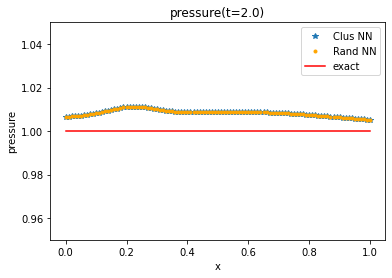

In [182]:
plot_final(TX,u,tmax)

In [231]:
plot_solution(TX,u)

InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/